In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
pd.options.mode.chained_assignment = None

In [2]:
# each tract's census info, along with all years' cum store months
df_final = pd.read_csv('data_for_DID.csv')

In [50]:
df_final

,Unnamed: 0,tract,year,rec,med,dispensary_status,match_id,population,income,house_value,rent,unemployment,poverty
0,0,8001007801,2014,0.0,0.0,0.0,180.0,4149.0,12675.0,156800.0,647.0,0.12,0.58
1,1,8001007801,2015,12.0,0.0,0.0,180.0,3930.0,12526.0,165800.0,665.0,0.07,0.56
2,2,8001007801,2016,24.0,0.0,0.0,180.0,4374.0,15885.0,162100.0,742.0,0.08,0.47
3,3,8001007801,2017,36.0,0.0,0.0,180.0,4412.0,17653.0,174300.0,818.0,0.10,0.44
4,4,8001007801,2018,48.0,0.0,0.0,180.0,4137.0,21320.0,208200.0,920.0,0.06,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5803,5803,8125963200,2017,0.0,0.0,0.0,322.0,5467.0,25463.0,151600.0,739.0,0.02,0.13
5804,5804,8125963200,2018,0.0,0.0,0.0,322.0,5713.0,26952.0,201500.0,840.0,0.02,0.15
5805,5805,8125963200,2019,0.0,0.0,0.0,322.0,5581.0,29879.0,205500.0,892.0,0.03,0.13
5806,5806,8125963200,2020,0.0,0.0,0.0,322.0,5827.0,32704.0,201900.0,878.0,0.04,0.10


In [166]:
def last_year_val(year, tract, df, outcome):
    if year ==2014:
        return 0
    else:
        curr_df = df[(df['year']==year-1)&(df['tract']==tract)]
        return curr_df[outcome].values[0]

--- --- --- --- --- --- --- --- --- --- --- ---
income
--- --- --- --- --- --- --- --- --- --- --- ---

Box Plot (original data)


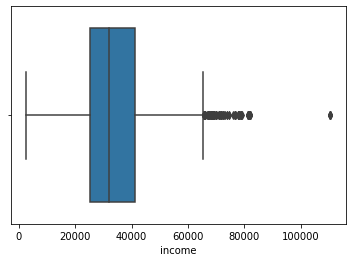

Box Plot (outliers removed)


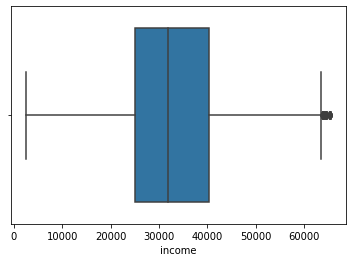

Coefficient:  [[-902.16062683 7571.20584981]]
Intercept:  [33433.10403098]
p-values:  x1    5.040534e-02
x2    2.983221e-59
Name: P>|t|, dtype: float64


--- --- --- --- --- --- --- --- --- --- --- ---
population
--- --- --- --- --- --- --- --- --- --- --- ---

Box Plot (original data)


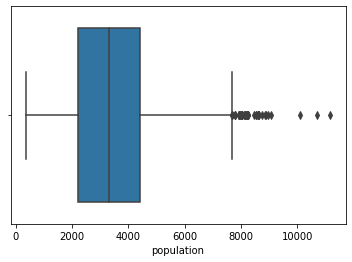

Box Plot (outliers removed)


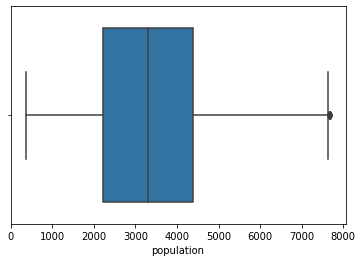

Coefficient:  [[-96.77945099 938.00447543]]
Intercept:  [3394.82521739]
p-values:  x1    4.066840e-02
x2    8.228189e-85
Name: P>|t|, dtype: float64


--- --- --- --- --- --- --- --- --- --- --- ---
house_value
--- --- --- --- --- --- --- --- --- --- --- ---

Box Plot (original data)


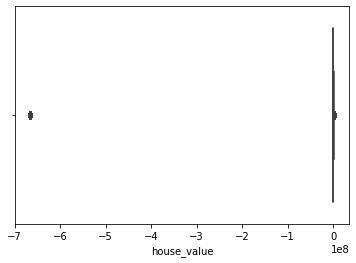

Box Plot (outliers removed)


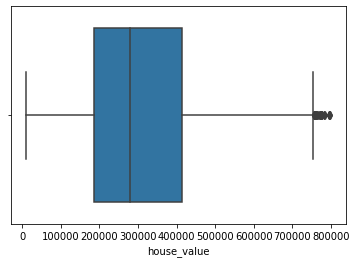

Coefficient:  [[ 3299.61972652 -5070.09986454]]
Intercept:  [312165.78255304]
p-values:  x1    0.488455
x2    0.287123
Name: P>|t|, dtype: float64


--- --- --- --- --- --- --- --- --- --- --- ---
rent
--- --- --- --- --- --- --- --- --- --- --- ---

Box Plot (original data)


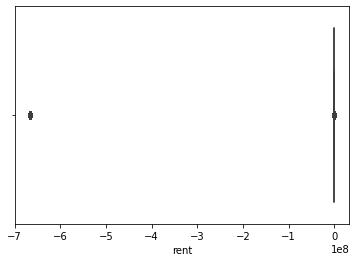

Box Plot (outliers removed)


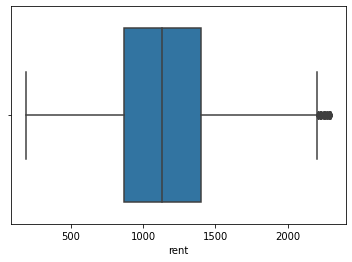

Coefficient:  [[-17.64654923  -7.87821514]]
Intercept:  [1168.36648551]
p-values:  x1    0.286598
x2    0.634247
Name: P>|t|, dtype: float64


--- --- --- --- --- --- --- --- --- --- --- ---
unemployment
--- --- --- --- --- --- --- --- --- --- --- ---

Box Plot (original data)


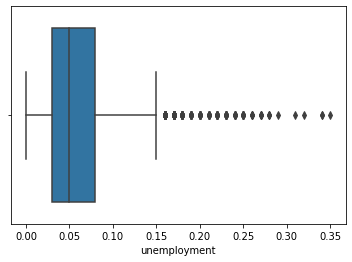

Box Plot (outliers removed)


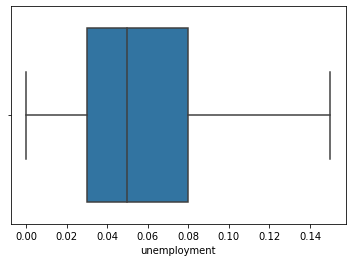

Coefficient:  [[-0.00290106  0.01828552]]
Intercept:  [0.05576259]
p-values:  x1     4.981854e-04
x2    1.342559e-102
Name: P>|t|, dtype: float64


--- --- --- --- --- --- --- --- --- --- --- ---
poverty
--- --- --- --- --- --- --- --- --- --- --- ---

Box Plot (original data)


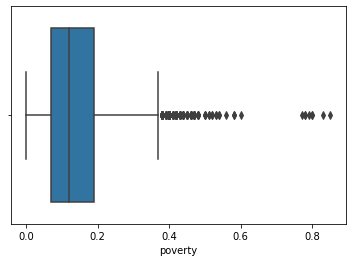

Box Plot (outliers removed)


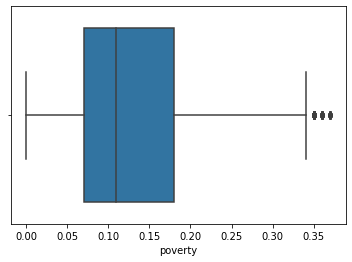

Coefficient:  [[-0.00449465  0.05856863]]
Intercept:  [0.12997339]
p-values:  x1     1.884414e-02
x2    1.585501e-190
Name: P>|t|, dtype: float64




In [178]:
for outcome in ['income', 'population', 'house_value', 'rent', 'unemployment', 'poverty']:
    print('--- --- --- --- --- --- --- --- --- --- --- ---')
    print(outcome)
    print('--- --- --- --- --- --- --- --- --- --- --- ---')
    df = df_final[['tract', 'year', 'rec', 'med', outcome]]
    df['total'] = df['rec'] + df['med']
    df['last_year'] = df.apply(lambda x: last_year_val(x['year'], x['tract'], df, outcome), axis=1)
    
    print()
    print('Box Plot (original data)')
    sns.boxplot(x=df[outcome])
    plt.show()

    Q1 = df[outcome].quantile(0.25)
    Q3 = df[outcome].quantile(0.75)
    IQR = Q3 - Q1
    Lower = Q1 - (1.5 * IQR)
    Upper = Q3 + (1.5 * IQR)


    #income_df['randNumCol'] = np.random.randint(0,50000, size=len(income_df))

    # remove outliers 
    print('Box Plot (outliers removed)')
    df_valid = df[(df[outcome]<=Upper)&(df[outcome]>=Lower)&(df[outcome]!=2014)]
    sns.boxplot(x=df_valid[outcome])
    plt.show()

    #prepare data
    X = df_valid[['total', 'last_year']]
    y = df_valid[[outcome]]

    # scale the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    #fit LR model
    lr = LinearRegression().fit(X,y)

    # print coefficient and intercept
    print('Coefficient: ', lr.coef_)
    print('Intercept: ', lr.intercept_)

    # get p value
    mod = sm.OLS(y,X)
    fii = mod.fit()
    p_values = fii.summary2().tables[1]['P>|t|']
    print('p-values: ', p_values)
    print()
    print()
